In [25]:
# ===================================================================
# IMPORTS
# ===================================================================
from functions import *


Libraries imported successfully
pymrio version: 0.5.4
Base path: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit
EXIOBASE data path: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\Exiobase3_ixi_latest
Results will be saved to: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\Results
Years for time series: 1995-2022
Loading population data from: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\code\producerappraoch\clean code\exiobase3_population_2022_official.csv
Population data shape: (49, 3)
Columns: ['EXIOBASE3_Code', 'Population_2022', 'Source']

First 5 rows:
  EXIOBASE3_Code  Population_2022             Source
0             AT       9041851.00  World Bank (2022)
1             BE      11680210.00  World Bank (2022)
2             BG       6643324.00  World Bank (2022)
3             CY       1331370.00  World Bank (2022)
4             CZ      10672118.00  World Bank (2022)
Defined 20 emission categories
Defined 9 total value-added components
  - 2 tax components
 

In [12]:

# ===================================================================
# LOAD DATA
# ===================================================================

# Load EXIOBASE for single year
ixi_data = load_exiobase_year(SINGLE_YEAR)



Loading EXIOBASE data for year 2019...
✓ Year 2019 loaded successfully
  Regions: 49
  Sectors: 163


In [ ]:
# Load population
population_2022 = load_population_data()

In [27]:
# ===================================================================
# SECTOR MAPPING
# ===================================================================

# Get all sectors from EXIOBASE
all_sectors = ixi_data.get_sectors()
print(f"Total sectors in EXIOBASE: {len(all_sectors)}")

# Create DataFrame with sector mapping
df_sectors = pd.DataFrame({'sector': all_sectors})
df_sectors['category'] = df_sectors['sector'].apply(category_of)
df_sectors['colour'] = df_sectors['sector'].apply(colour_of)

print("\nSector distribution:")
print(df_sectors['category'].value_counts())

# Check for unmapped sectors
unmapped = df_sectors[df_sectors['category'] == 'other']
if len(unmapped) > 0:
    print(f"\nWarning: {len(unmapped)} unmapped sectors:")
    print(unmapped['sector'].tolist())

# Create analysis-specific sector lists
fossil_sectors = get_sectors_by_categories(["Coal", "Oil", "Gas"])
service_sectors = get_sectors_by_categories(["Services"])

print(f"\nFossil fuel sectors: {len(fossil_sectors)}")
print(f"Service sectors: {len(service_sectors)}")


Total sectors in EXIOBASE: 163

Sector distribution:
Waste & Recycling                           23
Services                                    18
Agriculture                                 17
Metals                                      15
Manufacturing (Other)                       13
Manufacturing (Food & Beverages)            12
Manufacturing (Machinery & Equipment)        8
Non-metallic Minerals                        8
Chemicals & Plastics                         7
Renewables                                   7
Electricity & Heat Infrastructure            7
Transport                                    6
Gas                                          5
Oil                                          5
Manufacturing (Textiles, Leather & Wood)     4
Construction & Trade                         3
Coal                                         3
other                                        2
Name: category, dtype: int64

['Mining of chemical and fertilizer minerals, production of salt, other

In [18]:
# ===================================================================
# CALCULATE CLEAN VA COEFFICIENTS
# ===================================================================

# All components
v_clean_all, v_raw_all = calculate_clean_va_coefficients(
    ixi_data, VALUE_ADDED_COMPONENTS
)

# Profit only
v_clean_profit, v_raw_profit = calculate_clean_va_coefficients(
    ixi_data, PROFIT_COMPONENTS
)

# Without taxes
components_no_tax = [c for c in VALUE_ADDED_COMPONENTS if c not in TAX_COMPONENTS]
v_clean_no_tax, v_raw_no_tax = calculate_clean_va_coefficients(
    ixi_data, components_no_tax
)

# ===================================================================
# RUN RESPONSIBILITY CALCULATIONS
# ===================================================================

print("\n" + "="*70)
print("CALCULATING ALL RESPONSIBILITY METHODS")
print("="*70)

# Producer responsibility
producer_emissions, missing = calculate_producer_responsibility(
    ixi_data, EMISSION_CATEGORIES
)

# Consumer responsibility
consumer_by_country, consumer_details = calculate_consumer_responsibility(
    ixi_data, producer_emissions
)

# VABR - all components
vabr_all, vabr_all_details, consumer_baseline = calculate_vabr(
    ixi_data, producer_emissions, v_clean_all
)

# VABR - profit only
vabr_profit, vabr_profit_details, _ = calculate_vabr(
    ixi_data, producer_emissions, v_clean_profit
)

# VABR - no taxes
vabr_no_tax, vabr_no_tax_details, _ = calculate_vabr(
    ixi_data, producer_emissions, v_clean_no_tax
)

# Bottom-up (producer-centric)
bottom_up_profit = calculate_producer_centric_vabr(
    ixi_data, producer_emissions, v_clean_profit, method='leontief'
)

print("\n" + "="*70)
print("ALL CALCULATIONS COMPLETE")
print("="*70)


Calculating VA coefficients using 9 components...
  Set 0 negative VA values to 0
  Capped 37 coefficients > 1
  BEFORE cleaning: Min=0.0000, Max=1.7726
  AFTER cleaning:  Min=0.0000, Max=1.0000
Calculating VA coefficients using 4 components...
  Set 0 negative VA values to 0
  Capped 15 coefficients > 1
  BEFORE cleaning: Min=0.0000, Max=36.3956
  AFTER cleaning:  Min=0.0000, Max=1.0000
Calculating VA coefficients using 7 components...
  Set 0 negative VA values to 0
  Capped 59 coefficients > 1
  BEFORE cleaning: Min=0.0000, Max=37.3111
  AFTER cleaning:  Min=0.0000, Max=1.0000

CALCULATING ALL RESPONSIBILITY METHODS
Total producer emissions: 44.715 Gt CO2-eq
Total consumer emissions: 44.712 Gt CO2-eq

=== VABR CALCULATION ===
Return allocation details: False
Total consumer emissions: 44.712 Gt
Total VABR: 44.712 Gt, Error: 0.0000%

=== VABR CALCULATION ===
Return allocation details: False
Total consumer emissions: 44.712 Gt
Total VABR: 44.712 Gt, Error: 0.0000%

=== VABR CALCULATION

ANALYSIS

In [31]:
print("\n" + "="*70)
print(f"ANALYSIS 1: Top Emitters Comparison ({SINGLE_YEAR})")
print("="*70)

# Aggregate producer emissions by country
producer_by_country = {}
for region in ixi_data.get_regions():
    mask = ixi_data.x.index.get_level_values(0) == region
    region_indices = np.where(mask)[0]
    producer_by_country[region] = producer_emissions[region_indices].sum()

producer_totals = pd.Series(producer_by_country)

# Create comparison DataFrame
comparison = pd.DataFrame({
    'Producer': producer_totals / 1e9,
    'Consumer': consumer_by_country / 1e9,
    'VABR (All)': vabr_all / 1e9,
    'VABR (Profit)': vabr_profit / 1e9,
    'Bottom-Up': bottom_up_profit / 1e9
})

# Select top 7 countries (by sum across all methods)
country_totals = comparison.sum(axis=1)
top7_countries = country_totals.nlargest(7).index.tolist()

print(f"\nTop 7 countries: {top7_countries}")
print("\nComparison (Gt CO2-eq):")
print(comparison.loc[top7_countries].round(2))


ANALYSIS 1: Top Emitters Comparison (2019)

Top 7 countries: ['CN', 'US', 'WA', 'IN', 'WM', 'WF', 'RU']

Comparison (Gt CO2-eq):
    Producer  Consumer  VABR (All)  VABR (Profit)  Bottom-Up
CN     12.96     11.82       11.46          11.04       5.37
US      5.10      6.21        6.52           6.59       2.35
WA      3.52      3.70        3.07           2.37       2.17
IN      3.45      3.17        2.90           2.96       1.90
WM      3.06      2.54        2.45           2.77       2.06
WF      2.24      2.22        1.88           1.88       1.50
RU      2.04      1.55        1.52           1.61       1.33


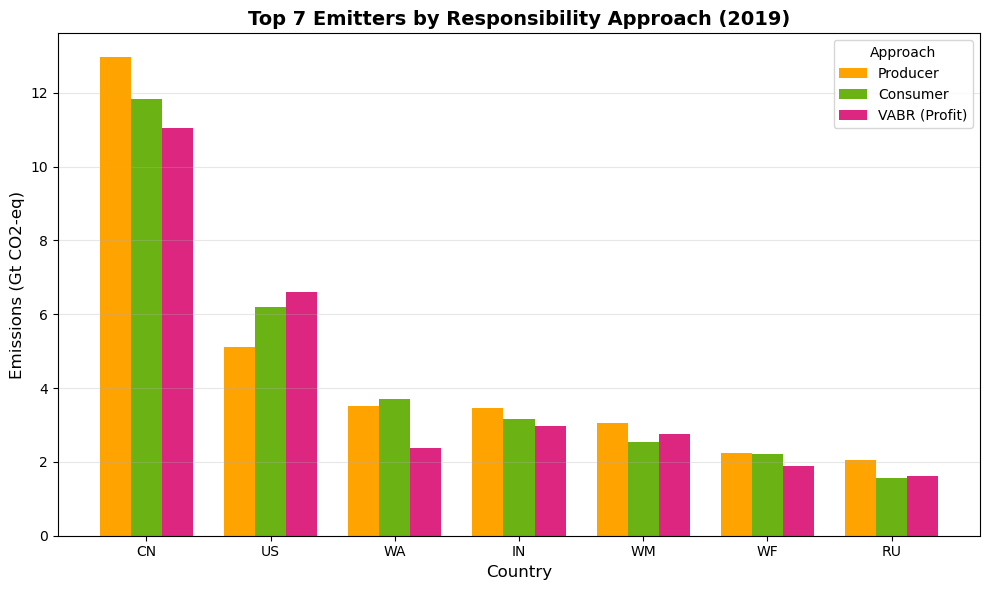

In [32]:
# ===================================================================
# GROUPED BAR PLOT
# ===================================================================

# Select which methods to plot
plot_data = comparison.loc[top7_countries, ['Producer', 'Consumer', 'VABR (Profit)']]

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(top7_countries))
width = 0.25
colors = ['#ffa300', '#6bb314', '#dc267f']

for i, (method, color) in enumerate(zip(plot_data.columns, colors)):
    ax.bar(
        x + (i - 1) * width,
        plot_data[method].values,
        width,
        label=method,
        color=color
    )

ax.set_title(f'Top 7 Emitters by Responsibility Approach ({SINGLE_YEAR})', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('Emissions (Gt CO2-eq)', fontsize=12)
ax.set_xlabel('Country', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(top7_countries)
ax.legend(title="Approach", fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



ANALYSIS 2: Per Capita Emissions (2019)

Countries with population data: 49

TOP 10 PER CAPITA EMITTERS (tonnes CO2-eq/person)

PRODUCER:
 1. AU:  20.98 tonnes/person
 2. CA:  17.18 tonnes/person
 3. US:  15.30 tonnes/person
 4. NO:  14.43 tonnes/person
 5. RU:  14.17 tonnes/person
 6. GR:  13.03 tonnes/person
 7. TW:  12.87 tonnes/person
 8. DK:  12.77 tonnes/person
 9. KR:  12.67 tonnes/person
10. FI:  12.15 tonnes/person

CONSUMER:
 1. LU:  22.65 tonnes/person
 2. CH:  19.15 tonnes/person
 3. IE:  18.76 tonnes/person
 4. US:  18.62 tonnes/person
 5. AU:  17.79 tonnes/person
 6. KR:  16.08 tonnes/person
 7. NO:  14.59 tonnes/person
 8. CA:  14.02 tonnes/person
 9. NL:  13.72 tonnes/person
10. BE:  12.90 tonnes/person

VABR (ALL):
 1. LU:  36.19 tonnes/person
 2. IE:  26.70 tonnes/person
 3. CH:  26.30 tonnes/person
 4. AU:  21.64 tonnes/person
 5. US:  19.57 tonnes/person
 6. NO:  18.87 tonnes/person
 7. DK:  17.36 tonnes/person
 8. KR:  17.30 tonnes/person
 9. NL:  17.15 tonnes/per

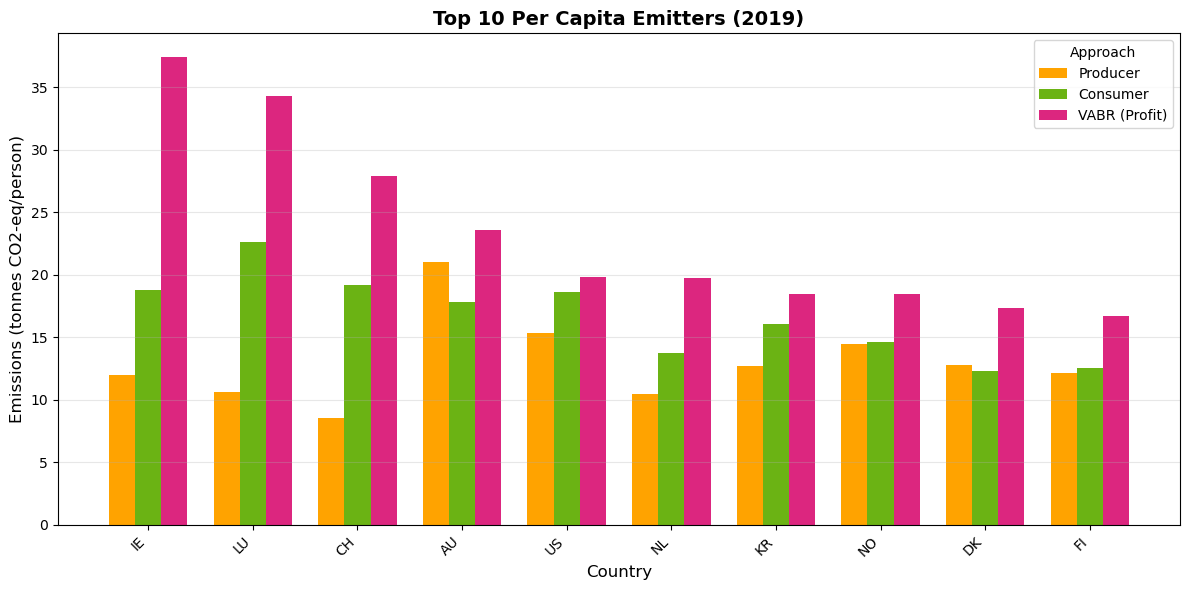

In [34]:
# ===================================================================
# ANALYSIS 2: PER CAPITA EMISSIONS
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS 2: Per Capita Emissions ({SINGLE_YEAR})")
print("="*70)

# Create per capita DataFrame
per_capita = pd.DataFrame({
    'Producer': producer_totals / population_2022,  # tonnes per person
    'Consumer': consumer_by_country / population_2022,
    'VABR (All)': vabr_all / population_2022,
    'VABR (Profit)': vabr_profit / population_2022,
    'Bottom-Up': bottom_up_profit / population_2022
})

# Remove countries with missing population data
per_capita = per_capita.dropna()

print(f"\nCountries with population data: {len(per_capita)}")

# Display top 10 for each approach
print("\n" + "="*70)
print("TOP 10 PER CAPITA EMITTERS (tonnes CO2-eq/person)")
print("="*70)

for method in per_capita.columns:
    print(f"\n{method.upper()}:")
    top10 = per_capita[method].nlargest(10)
    for i, (country, emissions) in enumerate(top10.items(), 1):
        print(f"{i:2d}. {country}: {emissions:6.2f} tonnes/person")

# ===================================================================
# PER CAPITA BAR PLOT
# ===================================================================

# Select top 10 countries by VABR (Profit) per capita
top10_per_capita = per_capita.nlargest(10, 'VABR (Profit)').index.tolist()

# Plot data
plot_data = per_capita.loc[top10_per_capita, ['Producer', 'Consumer', 'VABR (Profit)']]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(top10_per_capita))
width = 0.25
colors = ['#ffa300', '#6bb314', '#dc267f']

for i, (method, color) in enumerate(zip(plot_data.columns, colors)):
    ax.bar(
        x + (i - 1) * width,
        plot_data[method].values,
        width,
        label=method,
        color=color
    )

ax.set_title(f'Top 10 Per Capita Emitters ({SINGLE_YEAR})', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('Emissions (tonnes CO2-eq/person)', fontsize=12)
ax.set_xlabel('Country', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(top10_per_capita, rotation=45, ha='right')
ax.legend(title="Approach", fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



ANALYSIS 3: World Map - Dominant Method per Capita (2019)

Countries by dominant method:
VABR        30
Producer    14
Consumer     5
Name: dominant_method, dtype: int64

Expanded to 227 countries/territories
Countries with data: 161


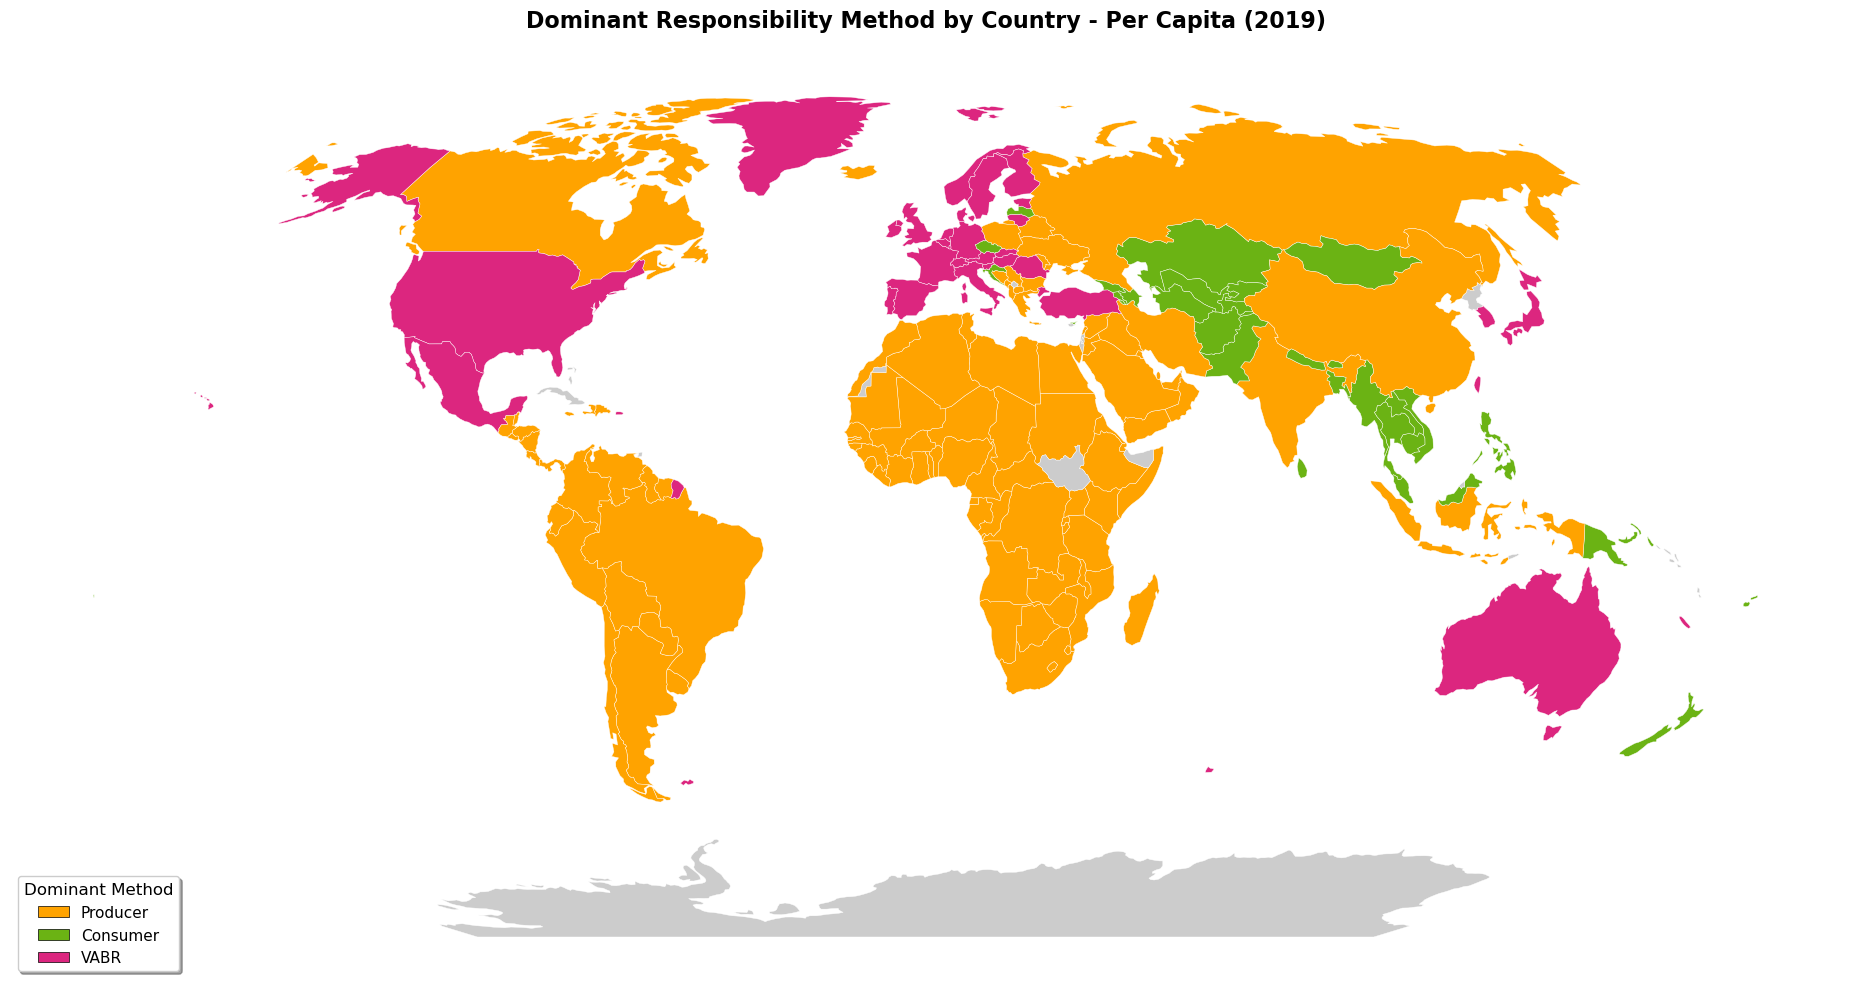


✓ World map created

Countries by dominant method:
Producer    98
VABR        34
Consumer    29
Name: dominant_method, dtype: int64


In [35]:
# ===================================================================
# ANALYSIS 3: WORLD MAP - DOMINANT RESPONSIBILITY METHOD
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS 3: World Map - Dominant Method per Capita ({SINGLE_YEAR})")
print("="*70)

import geopandas as gpd
from matplotlib.patches import Rectangle

# ===================================================================
# PREPARE DATA: Determine dominant method for each country
# ===================================================================

# Create DataFrame with all methods
map_input = pd.DataFrame({
    'Producer': per_capita['Producer'],
    'Consumer': per_capita['Consumer'],
    'VABR': per_capita['VABR (Profit)']  # or whichever VABR variant you want
})

# Find dominant method for each country
map_input['dominant_method'] = map_input[['Producer', 'Consumer', 'VABR']].idxmax(axis=1)
map_input['max_value'] = map_input[['Producer', 'Consumer', 'VABR']].max(axis=1)

print(f"\nCountries by dominant method:")
print(map_input['dominant_method'].value_counts())

# ===================================================================
# COUNTRY CODE MAPPING
# ===================================================================

# EXIOBASE country codes to shapefile SOV_A3 codes
exiobase_to_sov = {
    'AT': 'AUT', 'BE': 'BEL', 'BG': 'BGR', 'CY': 'CYN', 'CZ': 'CZE',
    'DE': 'DEU', 'DK': 'DN1', 'EE': 'EST', 'ES': 'ESP', 'FI': 'FI1',
    'FR': 'FR1', 'GR': 'GRC', 'HR': 'HRV', 'HU': 'HUN', 'IE': 'IRL',
    'IT': 'ITA', 'LT': 'LTU', 'LU': 'LUX', 'LV': 'LVA', 'MT': 'MLT',
    'NL': 'NL1', 'PL': 'POL', 'PT': 'PRT', 'RO': 'ROU', 'SE': 'SWE',
    'SI': 'SVN', 'SK': 'SVK', 'GB': 'GB1', 'US': 'US1', 'JP': 'JPN',
    'CN': 'CH1', 'CA': 'CAN', 'KR': 'KOR', 'BR': 'BRA', 'IN': 'IND',
    'MX': 'MEX', 'RU': 'RUS', 'AU': 'AU1', 'CH': 'CHE', 'TR': 'TUR',
    'TW': 'TWN', 'NO': 'NOR', 'ID': 'IDN', 'ZA': 'ZAF'
}

# ISO2 to SOV_A3 for ROW regions
iso2_to_sov = {
    'AF': 'AFG', 'AL': 'ALB', 'DZ': 'DZA', 'AO': 'AGO', 'AR': 'ARG',
    'AM': 'ARM', 'AZ': 'AZE', 'BD': 'BGD', 'BH': 'BHR', 'BY': 'BLR',
    'BZ': 'BLZ', 'BJ': 'BEN', 'BT': 'BTN', 'BO': 'BOL', 'BA': 'BIH',
    'BW': 'BWA', 'BF': 'BFA', 'BI': 'BDI', 'KH': 'KHM', 'CM': 'CMR',
    'CV': 'CPV', 'CF': 'CAF', 'TD': 'TCD', 'CL': 'CHL', 'CO': 'COL',
    'KM': 'COM', 'CG': 'COG', 'CD': 'COD', 'CR': 'CRI', 'CI': 'CIV',
    'CU': 'CUB', 'DJ': 'DJI', 'DO': 'DOM', 'EC': 'ECU', 'EG': 'EGY',
    'SV': 'SLV', 'GQ': 'GNQ', 'ER': 'ERI', 'ET': 'ETH', 'FJ': 'FJI',
    'GA': 'GAB', 'GM': 'GMB', 'GE': 'GEO', 'GH': 'GHA', 'GT': 'GTM',
    'GN': 'GIN', 'GW': 'GNB', 'GY': 'GUY', 'HT': 'HTI', 'HN': 'HND',
    'IS': 'ISL', 'IR': 'IRN', 'IQ': 'IRQ', 'IL': 'ISR', 'JM': 'JAM',
    'JO': 'JOR', 'KE': 'KEN', 'KW': 'KWT', 'KG': 'KGZ', 'LA': 'LAO',
    'LB': 'LBN', 'LS': 'LSO', 'LR': 'LBR', 'LY': 'LBY', 'MK': 'MKD',
    'MG': 'MDG', 'MW': 'MWI', 'MY': 'MYS', 'MV': 'MDV', 'ML': 'MLI',
    'MR': 'MRT', 'MU': 'MUS', 'MD': 'MDA', 'MN': 'MNG', 'ME': 'MNE',
    'MA': 'MAR', 'MZ': 'MOZ', 'MM': 'MMR', 'NA': 'NAM', 'NP': 'NPL',
    'NZ': 'NZ1', 'NI': 'NIC', 'NE': 'NER', 'NG': 'NGA', 'OM': 'OMN',
    'PK': 'PAK', 'PA': 'PAN', 'PG': 'PNG', 'PY': 'PRY', 'PE': 'PER',
    'PH': 'PHL', 'QA': 'QAT', 'RW': 'RWA', 'SA': 'SAU', 'SN': 'SEN',
    'RS': 'SRB', 'SC': 'SYC', 'SL': 'SLE', 'SG': 'SGP', 'SO': 'SOM',
    'LK': 'LKA', 'SD': 'SDN', 'SR': 'SUR', 'SZ': 'SWZ', 'SY': 'SYR',
    'TJ': 'TJK', 'TZ': 'TZA', 'TH': 'THA', 'TG': 'TGO', 'TN': 'TUN',
    'TM': 'TKM', 'UG': 'UGA', 'UA': 'UKR', 'AE': 'ARE', 'UY': 'URY',
    'UZ': 'UZB', 'VE': 'VEN', 'VN': 'VNM', 'YE': 'YEM', 'ZM': 'ZMB',
    'ZW': 'ZWE', 'KZ': 'KA1'
}

# ROW regions and their member countries
row_regions = {
    'WA': ['AF', 'AS', 'AM', 'AZ', 'BD', 'BT', 'BN', 'KH', 'CK', 'FJ', 'PF', 'GE',
           'GU', 'HK', 'KZ', 'KI', 'KP', 'KG', 'LA', 'MO', 'MY', 'MV', 'MH', 'FM',
           'MN', 'MM', 'NR', 'NP', 'NC', 'NZ', 'NU', 'MP', 'PK', 'PW', 'PG', 'PH',
           'PN', 'WS', 'SG', 'SB', 'LK', 'TJ', 'TH', 'TP', 'TK', 'TO', 'TM', 'TV',
           'UZ', 'VU', 'VN'],
    'WL': ['AI', 'AG', 'AR', 'AW', 'BS', 'BB', 'BZ', 'BM', 'BO', 'KY', 'CL', 'CO',
           'CR', 'CU', 'DM', 'DO', 'EC', 'SV', 'FK', 'GL', 'GD', 'GP', 'GT', 'GY',
           'HT', 'HN', 'JM', 'MQ', 'NI', 'PA', 'PY', 'PE', 'PR', 'KN', 'LC', 'PM',
           'VC', 'SR', 'TT', 'TC', 'UY', 'VE', 'VG', 'VI', 'GF'],
    'WE': ['AL', 'AD', 'BY', 'BA', 'FO', 'GI', 'IS', 'IM', 'LI', 'MK', 'MD', 'MC',
           'ME', 'SM', 'RS', 'UA', 'VA'],
    'WF': ['DZ', 'AO', 'BJ', 'BW', 'BF', 'BI', 'CM', 'CV', 'CF', 'TD', 'KM', 'CD',
           'CG', 'CI', 'DJ', 'GQ', 'EH', 'ER', 'ET', 'GA', 'GM', 'GH', 'GN', 'GW', 'KE',
           'LS', 'LR', 'LY', 'MG', 'MW', 'ML', 'MR', 'MU', 'YT', 'MA', 'MZ', 'NA',
           'NE', 'NG', 'RE', 'RW', 'ST', 'SN', 'SC', 'SL', 'SO', 'SH', 'SD', 'SZ',
           'TZ', 'TG', 'TN', 'UG', 'ZM', 'ZW'],
    'WM': ['BH', 'IR', 'IQ', 'IL', 'JO', 'KW', 'LB', 'OM', 'PS', 'QA', 'SA',
           'SY', 'AE', 'YE', 'EG']
}

# ===================================================================
# EXPAND DATA: Map EXIOBASE countries and ROW regions to shapefile
# ===================================================================

map_data = []

for country_code, row_data in map_input.iterrows():
    if country_code in exiobase_to_sov:
        # Individual EXIOBASE country
        map_data.append({
            'SOV_A3': exiobase_to_sov[country_code],
            'dominant_method': row_data['dominant_method'],
            'max_value': row_data['max_value'],
            'Producer': row_data['Producer'],
            'Consumer': row_data['Consumer'],
            'VABR': row_data['VABR']
        })
    elif country_code in row_regions:
        # ROW region - assign to all member countries
        for member_iso2 in row_regions[country_code]:
            member_sov = iso2_to_sov.get(member_iso2, member_iso2)
            map_data.append({
                'SOV_A3': member_sov,
                'dominant_method': row_data['dominant_method'],
                'max_value': row_data['max_value'],
                'Producer': row_data['Producer'],
                'Consumer': row_data['Consumer'],
                'VABR': row_data['VABR']
            })

map_df = pd.DataFrame(map_data)
print(f"\nExpanded to {len(map_df)} countries/territories")

# ===================================================================
# LOAD SHAPEFILE AND MERGE
# ===================================================================

# Load world shapefile
shapefile_path = BASE_PATH / "results" / "geodata" / "ne_110m_admin_0_countries" / "ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)
world = world.to_crs('ESRI:54030')  # Robinson projection

# Merge data
world = world.merge(map_df, on='SOV_A3', how='left')

print(f"Countries with data: {world['dominant_method'].notna().sum()}")

# ===================================================================
# CREATE MAP
# ===================================================================

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Method colors
method_colors = {
    'Producer': '#ffa300',
    'Consumer': '#6bb314',
    'VABR': '#dc267f'
}

# Assign colors
world['color'] = world['dominant_method'].map(method_colors)
world['color'] = world['color'].fillna('#CCCCCC')  # Gray for missing data

# Plot
world.plot(
    color=world['color'],
    linewidth=0.3,
    edgecolor='white',
    ax=ax,
    missing_kwds={'color': '#CCCCCC', 'edgecolor': 'white', 'linewidth': 0.3}
)

# Ocean background
ax.set_facecolor('#E6F3FF')
ax.axis('off')

# Title
ax.set_title(
    f'Dominant Responsibility Method by Country - Per Capita ({SINGLE_YEAR})',
    fontsize=16, fontweight='bold', pad=20
)

# Legend
legend_elements = [
    Rectangle((0, 0), 1, 1, fc='#ffa300', edgecolor='black', linewidth=0.5, label='Producer'),
    Rectangle((0, 0), 1, 1, fc='#6bb314', edgecolor='black', linewidth=0.5, label='Consumer'),
    Rectangle((0, 0), 1, 1, fc='#dc267f', edgecolor='black', linewidth=0.5, label='VABR')
]

ax.legend(
    handles=legend_elements,
    loc='lower left',
    title='Dominant Method',
    frameon=True,
    fancybox=True,
    shadow=True,
    fontsize=11,
    title_fontsize=12
)

plt.tight_layout()
plt.show()

print("\n✓ World map created")
print(f"\nCountries by dominant method:")
print(world['dominant_method'].value_counts())

In [38]:
# ===================================================================
# ANALYSIS 4: EFFICIENCY BIAS INVESTIGATION
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS 4: Efficiency Bias Investigation ({SINGLE_YEAR})")
print("="*70)

# ===================================================================
# STEP 1: Calculate metrics for all sector-regions
# ===================================================================

print("\n### STEP 1: Calculate Metrics ###")

# Get basic data
n_sectors = len(ixi_data.x)
total_output = ixi_data.x.values.flatten()
regions = ixi_data.get_regions()
sectors = ixi_data.get_sectors()

# Calculate emission intensity (kg CO2-eq per EUR output)
emission_intensity = np.divide(
    producer_emissions,
    total_output,
    out=np.zeros_like(producer_emissions),
    where=(total_output != 0)
)

# VA coefficient (we already have v_clean_all)
va_coefficient = v_clean_all

# Get producer and VABR responsibilities in tonnes
producer_resp = producer_emissions.copy()
vabr_resp = vabr_all.reindex(ixi_data.x.index).values  # Align with x index

# Create DataFrame
bias_df = pd.DataFrame({
    'region': ixi_data.x.index.get_level_values(0),
    'sector': ixi_data.x.index.get_level_values(1),
    'total_emissions': producer_resp / 1e9,  # Convert to Gt
    'emission_intensity': emission_intensity,
    'va_coefficient': va_coefficient,
    'output': total_output,
    'producer_resp': producer_resp / 1e9,  # Gt
    'vabr_resp': vabr_resp / 1e9  # Gt
}, index=ixi_data.x.index)

# Add sector category
bias_df['category'] = bias_df['sector'].apply(category_of)

print(f"Total sector-regions: {len(bias_df)}")
print(f"\nSummary statistics:")
print(bias_df[['emission_intensity', 'va_coefficient', 'total_emissions']].describe())


ANALYSIS 4: Efficiency Bias Investigation (2019)

### STEP 1: Calculate Metrics ###
Total sector-regions: 7987

Summary statistics:
       emission_intensity  va_coefficient  total_emissions
count             7987.00         7987.00          7987.00
mean        3545142878.28            0.32             0.01
std       225267659478.52            0.28             0.06
min                  0.00            0.00             0.00
25%                  1.08            0.01             0.00
50%                 32.93            0.29             0.00
75%                340.39            0.52             0.00
max     18790555987224.61            1.00             4.77


In [39]:
# ===================================================================
# STEP 2: Filter by emission threshold
# ===================================================================

print("\n### STEP 2: Apply Threshold Filter ###")

# Calculate global emission share
total_global_emissions = bias_df['total_emissions'].sum()
bias_df['emission_share'] = (bias_df['total_emissions'] / total_global_emissions) * 100

# Filter: only sector-regions with > 0.01% of global emissions
threshold = 0.01  # percent
bias_df_filtered = bias_df[bias_df['emission_share'] > threshold].copy()

print(f"Threshold: > {threshold}% of global emissions")
print(f"Sector-regions after filter: {len(bias_df_filtered)} (from {len(bias_df)})")
print(f"Coverage: {bias_df_filtered['total_emissions'].sum() / total_global_emissions * 100:.1f}% of global emissions")

# Sort by total emissions
bias_df_filtered = bias_df_filtered.sort_values('total_emissions', ascending=False)

print(f"\nTop 10 emitters:")
print(bias_df_filtered[['region', 'sector', 'total_emissions', 'emission_intensity', 'va_coefficient']].head(10))


### STEP 2: Apply Threshold Filter ###
Threshold: > 0.01% of global emissions
Sector-regions after filter: 854 (from 7987)
Coverage: 93.7% of global emissions

Top 10 emitters:
                                                          region  \
region sector                                                      
CN     Production of electricity by coal                      CN   
       Manufacture of basic iron and steel and of ferr...     CN   
       Manufacture of cement, lime and plaster                CN   
US     Production of electricity by coal                      US   
IN     Production of electricity by coal                      IN   
CN     Mining of coal and lignite; extraction of peat ...     CN   
US     Production of electricity by gas                       US   
WM     Extraction of crude petroleum and services rela...     WM   
WA     Production of electricity by coal                      WA   
WF     Cattle farming                                         WF   

     

In [40]:
# ===================================================================
# STEP 3: Explore patterns
# ===================================================================

print("\n### STEP 3: Pattern Exploration ###")

# A) Group by category - which sectors most affected?
category_summary = bias_df_filtered.groupby('category').agg({
    'total_emissions': 'sum',
    'emission_intensity': 'mean',
    'va_coefficient': 'mean'
}).sort_values('total_emissions', ascending=False)

print("\nEmissions by sector category:")
print(category_summary.head(15))

# B) Identify problematic sector-regions (high emissions, low VA)
# Define "problematic": emission_intensity > median AND va_coefficient < median
median_emis = bias_df_filtered['emission_intensity'].median()
median_va = bias_df_filtered['va_coefficient'].median()

problematic = bias_df_filtered[
    (bias_df_filtered['emission_intensity'] > median_emis) &
    (bias_df_filtered['va_coefficient'] < median_va)
].copy()

print(f"\n### Problematic sector-regions (high emissions, low VA): {len(problematic)} ###")
print("\nTop 20 most problematic:")
print(problematic[['region', 'sector', 'total_emissions', 'emission_intensity', 'va_coefficient']].head(20))

# C) By category - which categories in problematic zone?
print("\nProblematic sector-regions by category:")
print(problematic['category'].value_counts())


### STEP 3: Pattern Exploration ###

Emissions by sector category:
                                          total_emissions  emission_intensity  \
category                                                                        
Coal                                                10.89            18342.86   
Agriculture                                          6.54             3964.22   
Gas                                                  3.98             6939.16   
Oil                                                  3.72             3985.43   
Non-metallic Minerals                                2.82             2818.58   
Transport                                            2.65              957.56   
Waste & Recycling                                    2.33     461399114904.21   
Metals                                               2.04             2357.90   
Chemicals & Plastics                                 1.91            10889.16   
Manufacturing (Other)                    

In [41]:
# ===================================================================
# QUICK CHECK: Waste & Recycling Anomaly
# ===================================================================

print("\n" + "="*70)
print("WASTE & RECYCLING INVESTIGATION")
print("="*70)

# Filter for waste sectors
waste_sectors = bias_df_filtered[bias_df_filtered['category'] == 'Waste & Recycling'].copy()

print(f"\nWaste & Recycling sector-regions in filtered data: {len(waste_sectors)}")
print(f"\nSorted by emission intensity (highest first):")
print(waste_sectors[['region', 'sector', 'total_emissions', 'emission_intensity', 'va_coefficient', 'output']].sort_values('emission_intensity', ascending=False).head(20))

# Check for extreme outliers
print(f"\n### Outlier Analysis ###")
print(f"Max emission intensity in waste: {waste_sectors['emission_intensity'].max():.2e}")
print(f"Median emission intensity in waste: {waste_sectors['emission_intensity'].median():.2f}")
print(f"Mean emission intensity in waste: {waste_sectors['emission_intensity'].mean():.2e}")

# Check specific problematic sectors
extreme_waste = waste_sectors[waste_sectors['emission_intensity'] > 1e6]
print(f"\nExtreme outliers (emission intensity > 1 million):")
if len(extreme_waste) > 0:
    print(extreme_waste[['region', 'sector', 'total_emissions', 'emission_intensity', 'output']])
    
    # Investigate: is it because output is very low?
    print("\nInvestigating cause:")
    for idx, row in extreme_waste.iterrows():
        print(f"\n{row['region']} - {row['sector'][:50]}...")
        print(f"  Emissions: {row['total_emissions']:.6f} Gt")
        print(f"  Output: {row['output']:.2f} million EUR")
        print(f"  Ratio: {row['total_emissions']*1e9 / row['output'] if row['output'] > 0 else 'DIV BY ZERO':.2f} kg/EUR")
else:
    print("No extreme outliers found")

# Compare to other sectors
print(f"\n### Comparison to other categories ###")
print("Median emission intensity by category (top 10):")
category_medians = bias_df_filtered.groupby('category')['emission_intensity'].median().sort_values(ascending=False)
print(category_medians.head(10))


WASTE & RECYCLING INVESTIGATION

Waste & Recycling sector-regions in filtered data: 56

Sorted by emission intensity (highest first):
                                                          region  \
region sector                                                      
WF     Landfill of waste: Food                                WF   
       Landfill of waste: Paper                               WF   
WA     Landfill of waste: Paper                               WA   
       Landfill of waste: Textiles                            WA   
       Landfill of waste: Food                                WA   
       Landfill of waste: Plastic                             WA   
WL     Landfill of waste: Food                                WL   
       Landfill of waste: Paper                               WL   
MX     Manure treatment (conventional), storage and la...     MX   
WM     Landfill of waste: Paper                               WM   
       Landfill of waste: Food                   

In [42]:
# Check: Are there other sectors with very low output?
print("\n### Sectors with very low output (< 1 million EUR) ###")
low_output = bias_df_filtered[bias_df_filtered['output'] < 1.0].copy()
print(f"Sectors with output < 1 million EUR: {len(low_output)}")
print("\nBy category:")
print(low_output['category'].value_counts())

print("\nTop 20 by emission intensity:")
print(low_output.nlargest(20, 'emission_intensity')[['region', 'sector', 'total_emissions', 'emission_intensity', 'output']])


### Sectors with very low output (< 1 million EUR) ###
Sectors with output < 1 million EUR: 10

By category:
Waste & Recycling    10
Name: category, dtype: int64

Top 20 by emission intensity:
                                                          region  \
region sector                                                      
WF     Landfill of waste: Food                                WF   
       Landfill of waste: Paper                               WF   
WA     Landfill of waste: Paper                               WA   
       Landfill of waste: Textiles                            WA   
       Landfill of waste: Food                                WA   
       Landfill of waste: Plastic                             WA   
WL     Landfill of waste: Food                                WL   
       Landfill of waste: Paper                               WL   
MX     Manure treatment (conventional), storage and la...     MX   
WM     Waste water treatment, other                       

In [45]:
# Check specific waste sectors
print("\n### Waste Sectors VA Cleaning Details ###")

waste_check = bias_df[bias_df['category'] == 'Waste & Recycling'].copy()

# Add more details
waste_check['absolute_va'] = waste_check['va_coefficient'] * waste_check['output']

print("\nWaste sectors with output < 1:")
print(waste_check[waste_check['output'] < 1.0][
    ['region', 'sector', 'output', 'va_coefficient', 'absolute_va', 'total_emissions']
].sort_values('output'))

print("\nWaste sectors with output > 10:")
print(waste_check[waste_check['output'] > 10.0][
    ['region', 'sector', 'output', 'va_coefficient', 'absolute_va', 'total_emissions']
].sort_values('output', ascending=False).head(10))




### Waste Sectors VA Cleaning Details ###

Waste sectors with output < 1:
                                                          region  \
region sector                                                      
AT     Manure treatment (conventional), storage and la...     AT   
IN     Incineration of waste: Metals and Inert materials      IN   
       Incineration of waste: Plastic                         IN   
       Incineration of waste: Paper                           IN   
       Incineration of waste: Food                            IN   
...                                                          ...   
HR     Biogasification of sewage slugde, incl. land ap...     HR   
DK     Landfill of waste: Plastic                             DK   
SI     Incineration of waste: Plastic                         SI   
SK     Recycling of waste and scrap                           SK   
HR     Landfill of waste: Textiles                            HR   

                                        


ANALYSIS 5: Efficiency Bias Visualization (2019)
Excluding waste sectors from plot
Sectors in plot: 798
Total emissions covered: 39.55 Gt


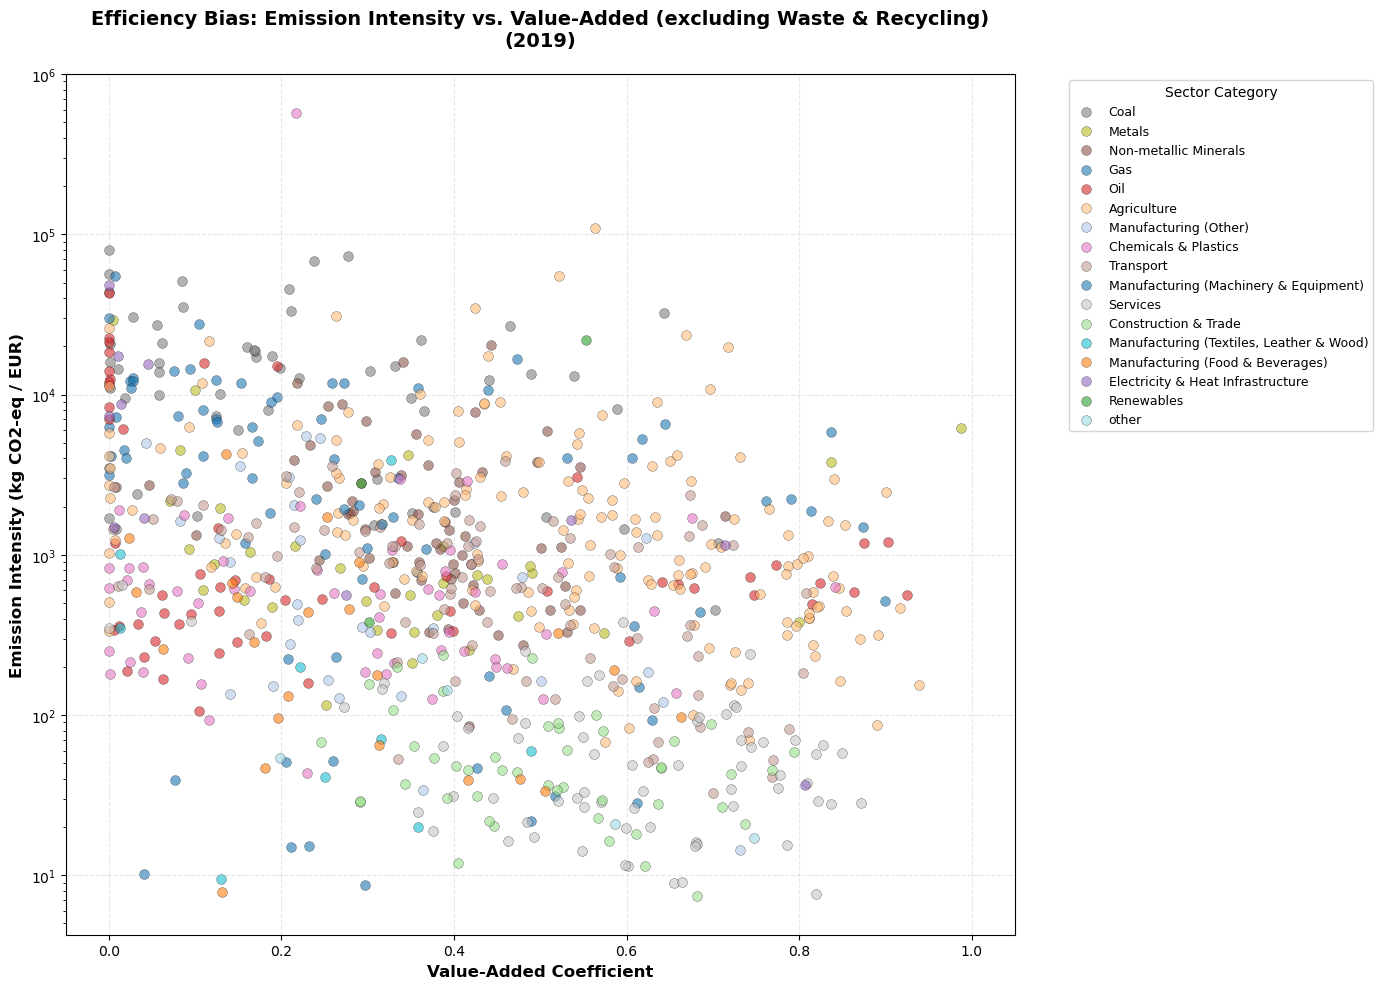


✓ Quadrant plot created

### Plot Statistics ###
X-axis (VA coefficient) range: 0.00 to 0.99
Y-axis (Emission intensity) range: 7.46 to 572598.59

Sectors by quadrant (using medians as dividers):
Median VA coefficient: 0.39
Median emission intensity: 741.17

High emissions, Low VA (BIAS ZONE): 251 sectors (21.07 Gt)
High emissions, High VA: 148 sectors (9.03 Gt)
Low emissions, Low VA: 148 sectors (4.12 Gt)
Low emissions, High VA (Services): 251 sectors (5.34 Gt)

Top 5 sectors in BIAS ZONE:
                                                          region  \
region sector                                                      
CN     Production of electricity by coal                      CN   
       Manufacture of basic iron and steel and of ferr...     CN   
       Manufacture of cement, lime and plaster                CN   
IN     Production of electricity by coal                      IN   
CN     Mining of coal and lignite; extraction of peat ...     CN   

                          

In [46]:
# ===================================================================
# ANALYSIS 5: EFFICIENCY BIAS QUADRANT PLOT
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS 5: Efficiency Bias Visualization ({SINGLE_YEAR})")
print("="*70)

# ===================================================================
# CONFIGURATION
# ===================================================================

INCLUDE_WASTE = False  # Set to True to include waste sectors

# ===================================================================
# PREPARE PLOT DATA
# ===================================================================

if INCLUDE_WASTE:
    plot_data = bias_df_filtered.copy()
    title_suffix = ""
    print("Including waste sectors in plot")
else:
    plot_data = bias_df_filtered[
        bias_df_filtered['category'] != 'Waste & Recycling'
    ].copy()
    title_suffix = " (excluding Waste & Recycling)"
    print("Excluding waste sectors from plot")

print(f"Sectors in plot: {len(plot_data)}")
print(f"Total emissions covered: {plot_data['total_emissions'].sum():.2f} Gt")

# ===================================================================
# CREATE PLOT
# ===================================================================

fig, ax = plt.subplots(figsize=(14, 10))

# Get unique categories and assign colors
categories = plot_data['category'].unique()
colors_map = {cat: sector_colours.get(cat, '#9edae5') for cat in categories}

# Plot each category separately for legend
for category in categories:
    cat_data = plot_data[plot_data['category'] == category]
    
    ax.scatter(
        cat_data['va_coefficient'],
        cat_data['emission_intensity'],
        c=colors_map[category],
        label=category,
        s=50,  # Fixed size for all points
        alpha=0.6,
        edgecolors='black',
        linewidths=0.3
    )

# Set y-axis to log scale
ax.set_yscale('log')

# Labels and title
ax.set_xlabel('Value-Added Coefficient', fontsize=12, fontweight='bold')
ax.set_ylabel('Emission Intensity (kg CO2-eq / EUR)', fontsize=12, fontweight='bold')
ax.set_title(
    f'Efficiency Bias: Emission Intensity vs. Value-Added{title_suffix}\n({SINGLE_YEAR})',
    fontsize=14,
    fontweight='bold',
    pad=20
)

# Grid
ax.grid(True, alpha=0.3, linestyle='--')

# Legend
ax.legend(
    title='Sector Category',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=True,
    fontsize=9,
    title_fontsize=10
)

# Set x-axis limits
ax.set_xlim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("\n✓ Quadrant plot created")

# ===================================================================
# SUMMARY STATISTICS
# ===================================================================

print("\n### Plot Statistics ###")
print(f"X-axis (VA coefficient) range: {plot_data['va_coefficient'].min():.2f} to {plot_data['va_coefficient'].max():.2f}")
print(f"Y-axis (Emission intensity) range: {plot_data['emission_intensity'].min():.2f} to {plot_data['emission_intensity'].max():.2f}")

print("\nSectors by quadrant (using medians as dividers):")
median_va = plot_data['va_coefficient'].median()
median_emis = plot_data['emission_intensity'].median()

print(f"Median VA coefficient: {median_va:.2f}")
print(f"Median emission intensity: {median_emis:.2f}")

# Count sectors in each quadrant
high_emis_low_va = plot_data[
    (plot_data['emission_intensity'] > median_emis) & 
    (plot_data['va_coefficient'] < median_va)
]
high_emis_high_va = plot_data[
    (plot_data['emission_intensity'] > median_emis) & 
    (plot_data['va_coefficient'] >= median_va)
]
low_emis_low_va = plot_data[
    (plot_data['emission_intensity'] <= median_emis) & 
    (plot_data['va_coefficient'] < median_va)
]
low_emis_high_va = plot_data[
    (plot_data['emission_intensity'] <= median_emis) & 
    (plot_data['va_coefficient'] >= median_va)
]

print(f"\nHigh emissions, Low VA (BIAS ZONE): {len(high_emis_low_va)} sectors ({high_emis_low_va['total_emissions'].sum():.2f} Gt)")
print(f"High emissions, High VA: {len(high_emis_high_va)} sectors ({high_emis_high_va['total_emissions'].sum():.2f} Gt)")
print(f"Low emissions, Low VA: {len(low_emis_low_va)} sectors ({low_emis_low_va['total_emissions'].sum():.2f} Gt)")
print(f"Low emissions, High VA (Services): {len(low_emis_high_va)} sectors ({low_emis_high_va['total_emissions'].sum():.2f} Gt)")

print(f"\nTop 5 sectors in BIAS ZONE:")
print(high_emis_low_va.nlargest(5, 'total_emissions')[
    ['region', 'sector', 'total_emissions', 'emission_intensity', 'va_coefficient']
])


PLOT 1: Top 30 Emitting Sectors - Efficiency Bias Analysis
Top 30 sectors represent: 18.06 Gt (45.7% of filtered total)


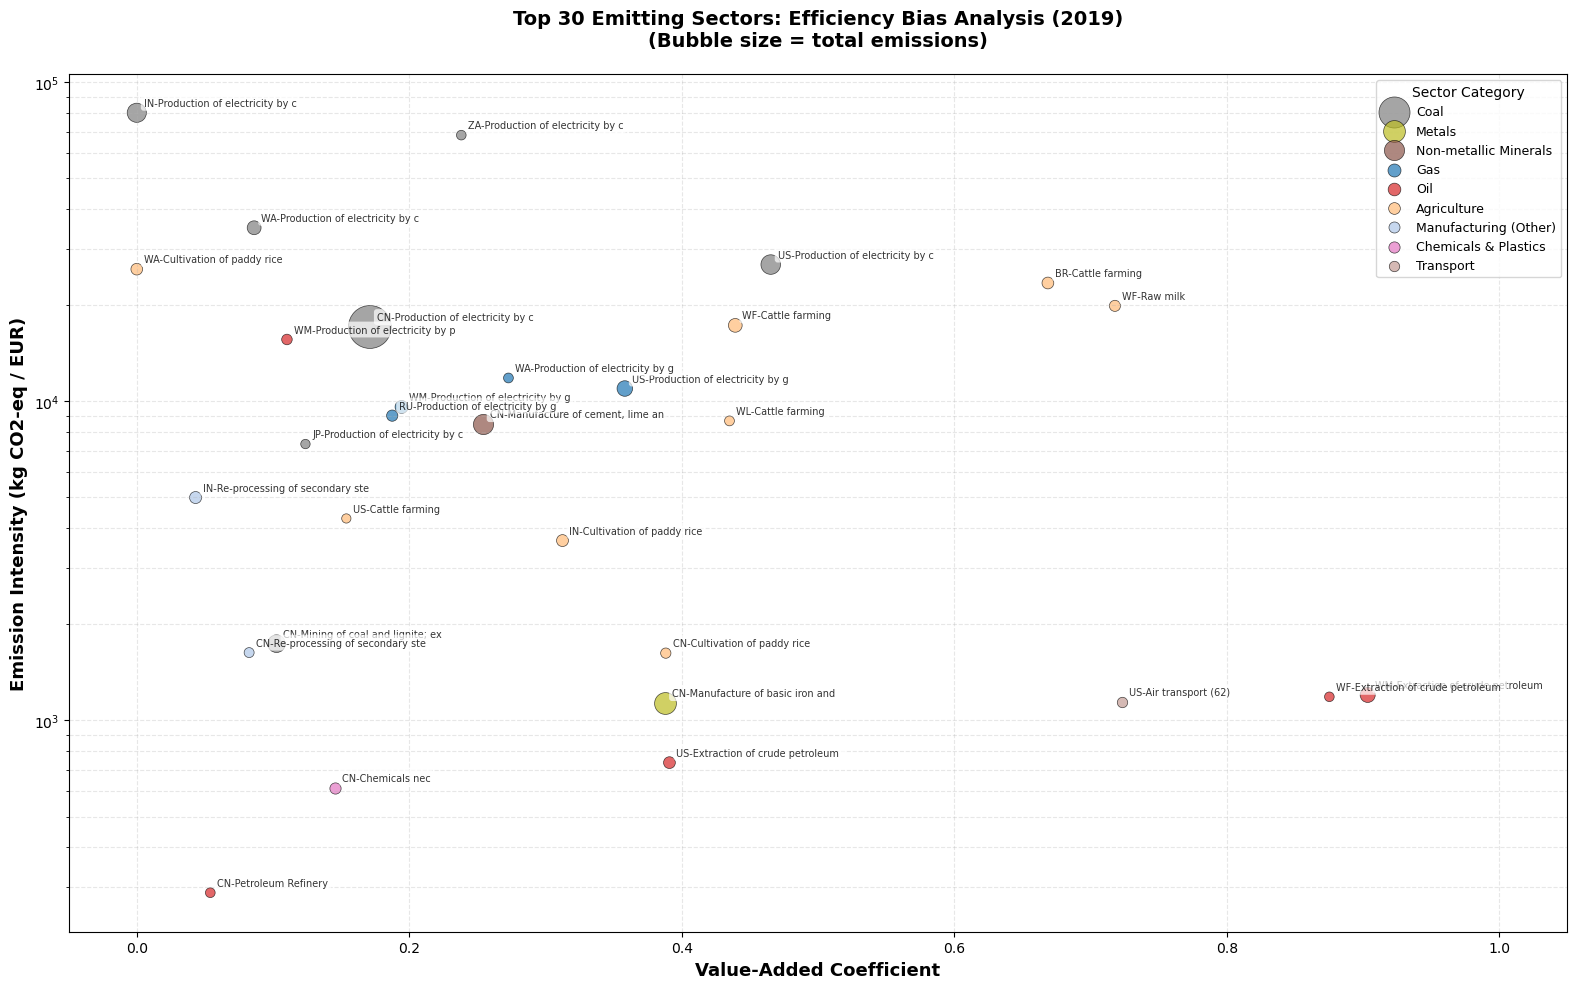


✓ Top 30 scatter plot created

Top 30 Sectors:
                                                                                                       region                                                                                           sector  total_emissions  emission_intensity  va_coefficient               category
region sector                                                                                                                                                                                                                                                                             
CN     Production of electricity by coal                                                                   CN                                                                Production of electricity by coal             4.77            17110.20            0.17                   Coal
       Manufacture of basic iron and steel and of ferro-alloys and first products thereof              

In [47]:
# ===================================================================
# PLOT 1: TOP 30 EMITTERS - DETAILED SCATTER
# ===================================================================

print("\n" + "="*70)
print("PLOT 1: Top 30 Emitting Sectors - Efficiency Bias Analysis")
print("="*70)

# Select top 30 by total emissions
top30 = plot_data.nlargest(30, 'total_emissions').copy()

print(f"Top 30 sectors represent: {top30['total_emissions'].sum():.2f} Gt ({top30['total_emissions'].sum()/plot_data['total_emissions'].sum()*100:.1f}% of filtered total)")

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Plot each category
for category in top30['category'].unique():
    cat_data = top30[top30['category'] == category]
    
    ax.scatter(
        cat_data['va_coefficient'],
        cat_data['emission_intensity'],
        c=[colors_map[category]],
        label=category,
        s=cat_data['total_emissions'] * 200,  # Size by emissions
        alpha=0.7,
        edgecolors='black',
        linewidths=0.5
    )

# Add labels for each point
for idx, row in top30.iterrows():
    region = row['region']
    sector_short = row['sector'][:30]  # Truncate long names
    
    # Offset text slightly to avoid overlap
    ax.annotate(
        f"{region}-{sector_short}",
        xy=(row['va_coefficient'], row['emission_intensity']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=7,
        alpha=0.8,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none')
    )

# Set y-axis to log scale
ax.set_yscale('log')

# Labels and title
ax.set_xlabel('Value-Added Coefficient', fontsize=13, fontweight='bold')
ax.set_ylabel('Emission Intensity (kg CO2-eq / EUR)', fontsize=13, fontweight='bold')
ax.set_title(
    f'Top 30 Emitting Sectors: Efficiency Bias Analysis ({SINGLE_YEAR})\n(Bubble size = total emissions)',
    fontsize=14,
    fontweight='bold',
    pad=20
)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', which='both')

# Legend
ax.legend(
    title='Sector Category',
    loc='upper right',
    frameon=True,
    fontsize=9,
    title_fontsize=10
)

# Set x-axis limits
ax.set_xlim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("\n✓ Top 30 scatter plot created")

# Print the list
print("\nTop 30 Sectors:")
print(top30[['region', 'sector', 'total_emissions', 'emission_intensity', 'va_coefficient', 'category']].to_string())


PLOT 2: Coal Sectors Deep Dive - Scatter Plot
Total coal sectors: 56
Coal emissions: 10.89 Gt
Top 20 coal sectors represent: 10.10 Gt (92.8% of coal total)


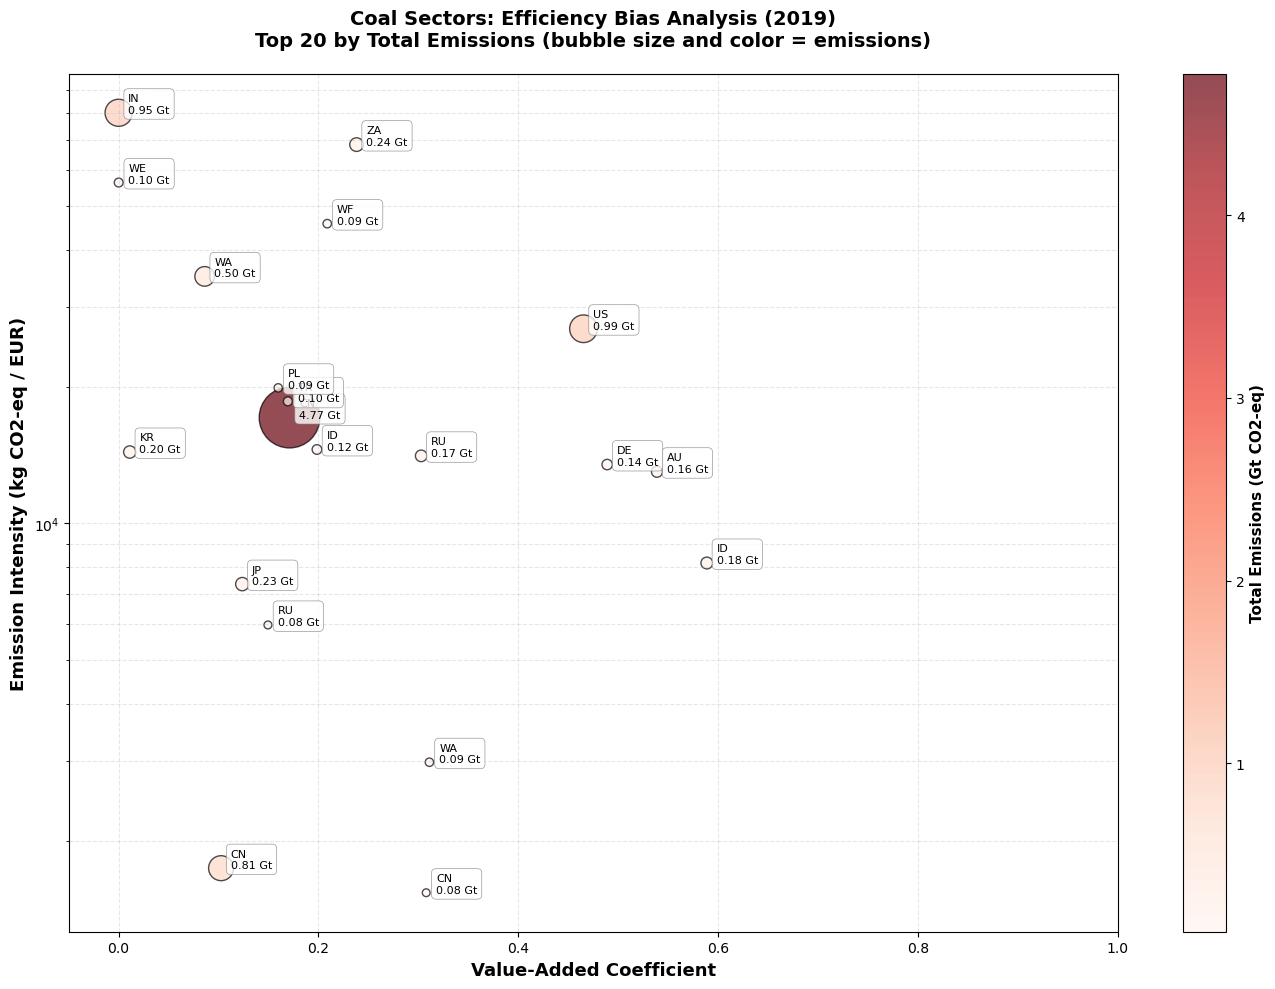


✓ Coal deep dive scatter plot created

Top 20 Coal Sectors:
                                                           region                                               sector  total_emissions  emission_intensity  va_coefficient
region sector                                                                                                                                                              
CN     Production of electricity by coal                       CN                    Production of electricity by coal             4.77            17110.20            0.17
US     Production of electricity by coal                       US                    Production of electricity by coal             0.99            26847.08            0.47
IN     Production of electricity by coal                       IN                    Production of electricity by coal             0.95            80275.53            0.00
CN     Mining of coal and lignite; extraction of peat (10)     CN  Mining of co

In [50]:
# ===================================================================
# PLOT 2: COAL SECTORS DEEP DIVE - SCATTER PLOT
# ===================================================================

print("\n" + "="*70)
print("PLOT 2: Coal Sectors Deep Dive - Scatter Plot")
print("="*70)

# Filter for coal sectors only
coal_sectors = plot_data[plot_data['category'] == 'Coal'].copy()

print(f"Total coal sectors: {len(coal_sectors)}")
print(f"Coal emissions: {coal_sectors['total_emissions'].sum():.2f} Gt")

# Select top 20 coal sectors by emissions
top20_coal = coal_sectors.nlargest(20, 'total_emissions').copy()

print(f"Top 20 coal sectors represent: {top20_coal['total_emissions'].sum():.2f} Gt ({top20_coal['total_emissions'].sum()/coal_sectors['total_emissions'].sum()*100:.1f}% of coal total)")

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

# Scatter plot
scatter = ax.scatter(
    top20_coal['va_coefficient'],
    top20_coal['emission_intensity'],
    s=top20_coal['total_emissions'] * 400,  # Size by emissions
    c=top20_coal['total_emissions'],  # Color by emissions
    cmap='Reds',
    alpha=0.7,
    edgecolors='black',
    linewidths=1
)

# Add labels for each point
for idx, row in top20_coal.iterrows():
    region = row['region']
    sector_short = row['sector'][:35]  # Truncate long names
    emissions_gt = row['total_emissions']
    
    # Label with region and emissions
    label_text = f"{region}\n{emissions_gt:.2f} Gt"
    
    ax.annotate(
        label_text,
        xy=(row['va_coefficient'], row['emission_intensity']),
        xytext=(7, 0),
        textcoords='offset points',
        fontsize=8,
        ha='left',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='gray', linewidth=0.5)
    )

# Set y-axis to log scale
ax.set_yscale('log')

# Labels and title
ax.set_xlabel('Value-Added Coefficient', fontsize=13, fontweight='bold')
ax.set_ylabel('Emission Intensity (kg CO2-eq / EUR)', fontsize=13, fontweight='bold')
ax.set_title(
    f'Coal Sectors: Efficiency Bias Analysis ({SINGLE_YEAR})\nTop 20 by Total Emissions (bubble size and color = emissions)',
    fontsize=14,
    fontweight='bold',
    pad=20
)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', which='both')

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Total Emissions (Gt CO2-eq)', fontsize=11, fontweight='bold')

# Set x-axis limits
ax.set_xlim(-0.05, 1)  

plt.tight_layout()
plt.show()

print("\n✓ Coal deep dive scatter plot created")

# Print the list
print("\nTop 20 Coal Sectors:")
print(top20_coal[['region', 'sector', 'total_emissions', 'emission_intensity', 'va_coefficient']].sort_values('total_emissions', ascending=False).to_string())

# Statistics
print("\n### Key Observations ###")
print(f"Highest emission intensity: {top20_coal['emission_intensity'].max():.0f} kg/EUR")
highest_ei = top20_coal.loc[top20_coal['emission_intensity'].idxmax()]
print(f"  → {highest_ei['region']} - {highest_ei['sector'][:50]}")

print(f"\nLowest VA coefficient: {top20_coal['va_coefficient'].min():.2f}")
lowest_va = top20_coal.loc[top20_coal['va_coefficient'].idxmin()]
print(f"  → {lowest_va['region']} - {lowest_va['sector'][:50]}")

print(f"\nLargest emitter: {top20_coal['total_emissions'].max():.2f} Gt")
largest = top20_coal.loc[top20_coal['total_emissions'].idxmax()]
print(f"  → {largest['region']} - {largest['sector'][:50]}")
print(f"     EI: {largest['emission_intensity']:.0f}, VA: {largest['va_coefficient']:.2f}")


               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0



PLOT 2: Coal Sectors Deep Dive - Scatter Plot
Total coal sectors: 56
Coal emissions: 10.89 Gt
Top 20 coal sectors represent: 10.10 Gt (92.8% of coal total)


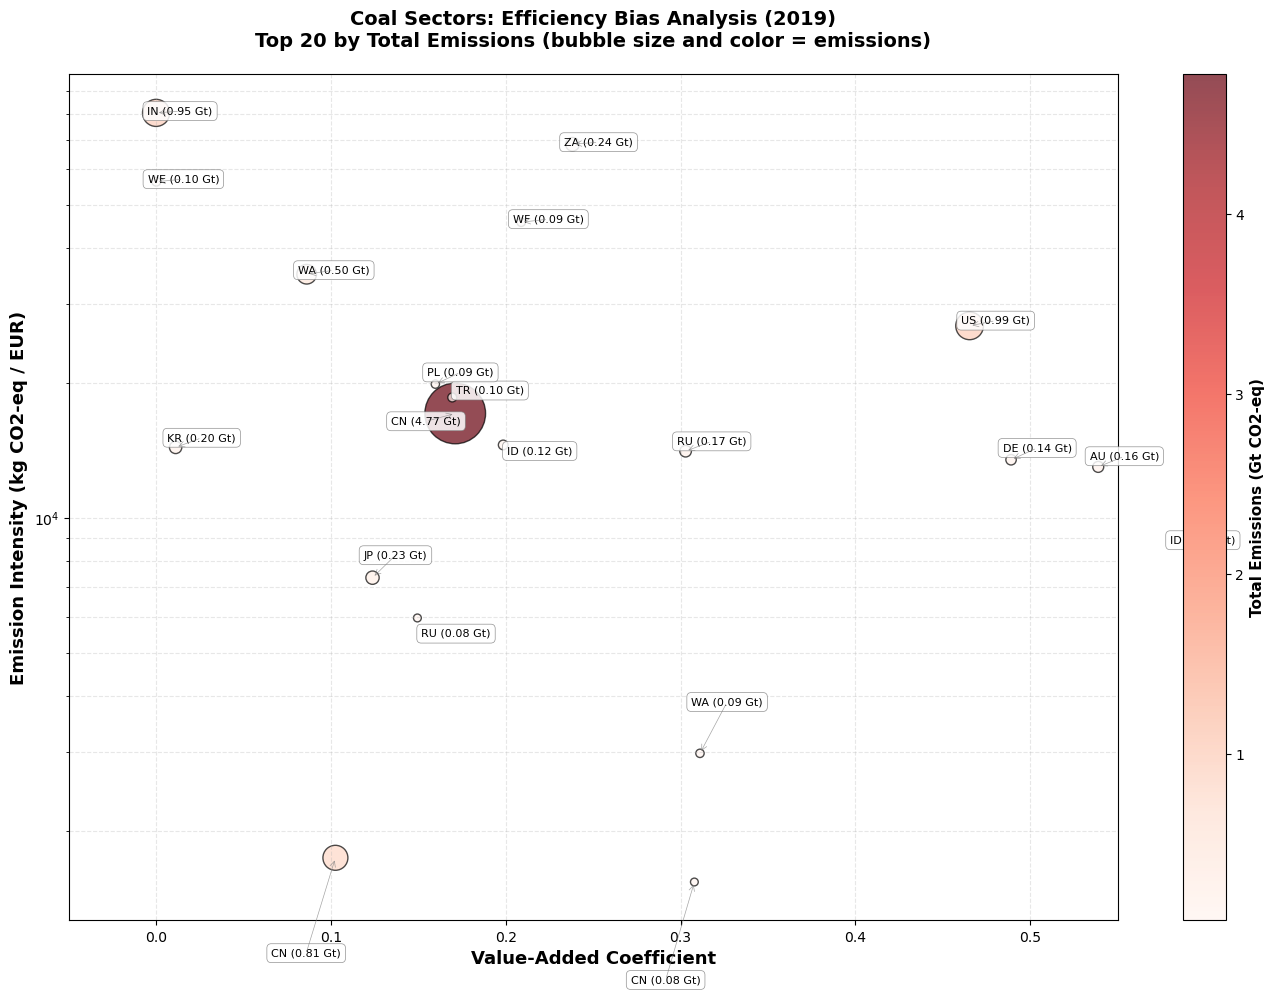


✓ Coal deep dive scatter plot created

Top 20 Coal Sectors:
                                                           region                                               sector  total_emissions  emission_intensity  va_coefficient
region sector                                                                                                                                                              
CN     Production of electricity by coal                       CN                    Production of electricity by coal             4.77            17110.20            0.17
US     Production of electricity by coal                       US                    Production of electricity by coal             0.99            26847.08            0.47
IN     Production of electricity by coal                       IN                    Production of electricity by coal             0.95            80275.53            0.00
CN     Mining of coal and lignite; extraction of peat (10)     CN  Mining of co

In [51]:
# ===================================================================
# PLOT 2: COAL SECTORS DEEP DIVE - SCATTER PLOT (with non-overlapping labels)
# ===================================================================

print("\n" + "="*70)
print("PLOT 2: Coal Sectors Deep Dive - Scatter Plot")
print("="*70)

# Install adjustText if not available (run once)
try:
    from adjustText import adjust_text
except ImportError:
    print("Installing adjustText library...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'adjustText', '--break-system-packages'])
    from adjustText import adjust_text

# Filter for coal sectors only
coal_sectors = plot_data[plot_data['category'] == 'Coal'].copy()

print(f"Total coal sectors: {len(coal_sectors)}")
print(f"Coal emissions: {coal_sectors['total_emissions'].sum():.2f} Gt")

# Select top 20 coal sectors by emissions
top20_coal = coal_sectors.nlargest(20, 'total_emissions').copy()

print(f"Top 20 coal sectors represent: {top20_coal['total_emissions'].sum():.2f} Gt ({top20_coal['total_emissions'].sum()/coal_sectors['total_emissions'].sum()*100:.1f}% of coal total)")

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

# Scatter plot
scatter = ax.scatter(
    top20_coal['va_coefficient'],
    top20_coal['emission_intensity'],
    s=top20_coal['total_emissions'] * 400,  # Size by emissions
    c=top20_coal['total_emissions'],  # Color by emissions
    cmap='Reds',
    alpha=0.7,
    edgecolors='black',
    linewidths=1
)

# Create list of text annotations
texts = []
for idx, row in top20_coal.iterrows():
    region = row['region']
    emissions_gt = row['total_emissions']
    
    # Label with region and emissions
    label_text = f"{region} ({emissions_gt:.2f} Gt)"
    
    txt = ax.text(
        row['va_coefficient'],
        row['emission_intensity'],
        label_text,
        fontsize=8,
        ha='center',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.85, edgecolor='gray', linewidth=0.5)
    )
    texts.append(txt)

# Adjust text positions to avoid overlap
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='->', color='gray', lw=0.5, alpha=0.7),
    expand_points=(1.5, 1.5),
    force_points=(0.5, 0.5)
)

# Set y-axis to log scale
ax.set_yscale('log')

# Labels and title
ax.set_xlabel('Value-Added Coefficient', fontsize=13, fontweight='bold')
ax.set_ylabel('Emission Intensity (kg CO2-eq / EUR)', fontsize=13, fontweight='bold')
ax.set_title(
    f'Coal Sectors: Efficiency Bias Analysis ({SINGLE_YEAR})\nTop 20 by Total Emissions (bubble size and color = emissions)',
    fontsize=14,
    fontweight='bold',
    pad=20
)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', which='both')

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Total Emissions (Gt CO2-eq)', fontsize=11, fontweight='bold')

# Set x-axis limits
ax.set_xlim(-0.05, 0.55)  # Most coal has VA < 0.5

plt.tight_layout()
plt.show()

print("\n✓ Coal deep dive scatter plot created")

# Print the list
print("\nTop 20 Coal Sectors:")
print(top20_coal[['region', 'sector', 'total_emissions', 'emission_intensity', 'va_coefficient']].sort_values('total_emissions', ascending=False).to_string())

# Statistics
print("\n### Key Observations ###")
print(f"Highest emission intensity: {top20_coal['emission_intensity'].max():.0f} kg/EUR")
highest_ei = top20_coal.loc[top20_coal['emission_intensity'].idxmax()]
print(f"  → {highest_ei['region']} - {highest_ei['sector'][:50]}")

print(f"\nLowest VA coefficient: {top20_coal['va_coefficient'].min():.2f}")
lowest_va = top20_coal.loc[top20_coal['va_coefficient'].idxmin()]
print(f"  → {lowest_va['region']} - {lowest_va['sector'][:50]}")

print(f"\nLargest emitter: {top20_coal['total_emissions'].max():.2f} Gt")
largest = top20_coal.loc[top20_coal['total_emissions'].idxmax()]
print(f"  → {largest['region']} - {largest['sector'][:50]}")
print(f"     EI: {largest['emission_intensity']:.0f}, VA: {largest['va_coefficient']:.2f}")